In [1]:
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import solve, lstsq, eigvalsh, eigh

# Plot defaults for quick diagnostics.
plt.rcParams["figure.dpi"] = 135

# Local data locations.
DATA      = Path(r"C:\Users\bseis\ABthesis\data")
PROCESSED = DATA / "processed"
ANALYSIS  = DATA / "analysis"

# Training-period universe/core and the as-of date used for snapshots.
TRAIN_UNIVERSE = PROCESSED / "crsp_weekly_universe_1997-01-01_to_2018-06-29_top1000_liq20p_rebalance-monthly_W-FRI.parquet"
TRAIN_CORE     = PROCESSED / "crsp_weekly_core_1997-01-01_to_2018-06-29.parquet"
ASOF_DATE      = pd.Timestamp("2018-06-29")

# Precomputed raw MI kernel (bits) for the same training universe.
MI_FILE = ANALYSIS / "mi_bits_tier1_asof20180629_k6_min156_sqrt.parquet"

# Numerical settings for kernel conditioning and frontier resolution.
RET_COL_CHOICES = ("ret_total", "ret")
RIDGE_MIN_EIG   = 1e-6
KAPPA_MAX       = 1e8
N_GAMMAS        = 800

def sanitize_kernel_bits(df: pd.DataFrame, name: str = "MI") -> pd.DataFrame:
    """
    Clean MI kernel for downstream linear algebra:
      - enforce finiteness (NaN/inf → 0)
      - floor negatives to 0
      - symmetrize
      - zero diagonal
    """
    assert df.index.equals(df.columns), f"{name}: index != columns"
    A = df.to_numpy(dtype="float64", copy=True)

    bad = ~np.isfinite(A)
    if bad.any():
        print(f"[{name}] non-finite → 0 (count={int(bad.sum())})")
        A[bad] = 0.0

    A = np.maximum(A, 0.0)
    A = 0.5 * (A + A.T)
    np.fill_diagonal(A, 0.0)
    return pd.DataFrame(A, index=df.index, columns=df.columns)

def nearest_psd(A: np.ndarray, eps_eig: float = 0.0) -> np.ndarray:
    # PSD projection via eigenvalue clipping.
    A = 0.5 * (A + A.T)
    w, V = eigh(A)
    w = np.maximum(w, eps_eig)
    B = (V * w) @ V.T
    return 0.5 * (B + B.T)

def choose_ridge(
    Qpsd: np.ndarray,
    target_min: float = RIDGE_MIN_EIG,
    kappa_max: float = KAPPA_MAX,
    max_steps: int = 12,
) -> float:
    # Increase a diagonal ridge on a log grid until min-eig and conditioning targets are met.
    w = eigvalsh(Qpsd)
    cond = w[-1] / max(w[0], 1e-16)
    if (w[0] >= target_min) and (cond <= kappa_max):
        return 0.0

    ridge = 1e-8
    for _ in range(max_steps):
        w2 = eigvalsh(Qpsd + ridge * np.eye(Qpsd.shape[0]))
        cond2 = w2[-1] / max(w2[0], 1e-16)
        if (w2[0] >= target_min) and (cond2 <= kappa_max):
            return ridge
        ridge *= 10.0

    print(f"[Q] warning: using ridge={ridge/10:.1e} (target cond not reached).")
    return ridge / 10.0

def _norm(df: pd.DataFrame) -> pd.DataFrame:
    # Standardize key columns for joins and filters.
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    if "permno" in df.columns:
        df["permno"] = pd.to_numeric(df["permno"], errors="coerce").astype("Int64")
    if "ticker" in df.columns:
        df["ticker"] = df["ticker"].astype(str).str.upper()
    return df

def load_train(universe_path: Path, core_path: Path) -> pd.DataFrame:
    """
    Load training returns in a tidy format: [date, permno, ticker, ret_used].

    If the universe file already contains returns, use them directly; otherwise
    join returns in from the core panel.
    """
    assert universe_path.exists(), f"Missing universe: {universe_path}"
    uni = _norm(pd.read_parquet(universe_path))
    uni = uni[(uni["date"] >= "1997-01-01") & (uni["date"] <= "2018-06-29")]

    ret_col = next((c for c in RET_COL_CHOICES if c in uni.columns), None)
    if ret_col is not None:
        return (
            uni.loc[:, ["date", "permno", "ticker", ret_col]]
               .rename(columns={ret_col: "ret_used"})
        )

    assert core_path.exists(), f"Missing core: {core_path}"
    core = _norm(pd.read_parquet(core_path))
    core = core[(core["date"] >= "1997-01-01") & (core["date"] <= "2018-06-29")]

    rc = next((c for c in RET_COL_CHOICES if c in core.columns), None)
    assert rc is not None, f"Returns column not found in {core_path.name}"

    keys = uni[["date", "permno"]].dropna()
    keys["permno"] = pd.to_numeric(keys["permno"], errors="coerce").astype("Int64")
    df = core.merge(keys.drop_duplicates(), on=["date", "permno"], how="inner")

    return (
        df.loc[:, ["date", "permno", "ticker", rc]]
          .rename(columns={rc: "ret_used"})
    )

def map_labels_to_tickers(R: pd.DataFrame, df_train: pd.DataFrame) -> dict:
    """
    Map kernel labels to tickers using a mix of label parsing and as-of PERMNO→ticker mapping.
    """
    snap = (
        df_train[df_train["date"] <= ASOF_DATE][["date", "permno", "ticker"]]
        .dropna(subset=["permno"])
        .sort_values(["permno", "date"])
        .groupby("permno", observed=True)
        .tail(1)
    )
    pno2tkr = dict(
        zip(
            snap["permno"].astype(int),
            snap["ticker"].astype(str).str.upper(),
        )
    )

    lab2tkr = {}
    for lbl in R.index:
        s = str(lbl)

        # Try grabbing a ticker-like token before a dash/emdash.
        t = s.split("—")[0].split(" - ")[0].strip().upper()
        if t.isalpha():
            lab2tkr[lbl] = t
            continue

        # Otherwise, try trailing PERMNO digits and map to the as-of ticker.
        m = re.search(r"(\d{4,7})$", s)
        if m:
            p = int(m.group(1))
            if p in pno2tkr:
                lab2tkr[lbl] = pno2tkr[p]

    return lab2tkr

def pivot_train(df_train: pd.DataFrame, lab2tkr: dict, labels: list) -> pd.DataFrame:
    """
    Wide weekly returns matrix aligned to kernel labels (index=date, columns=labels).
    """
    piv = (
        df_train[["date", "ticker", "ret_used"]]
        .dropna()
        .assign(ticker=lambda d: d["ticker"].astype(str).str.upper())
        .pivot_table(index="date", columns="ticker", values="ret_used", aggfunc="last")
        .sort_index()
        .dropna(how="all")
        .clip(lower=-0.99, upper=5.0)
    )

    keep = [lbl for lbl in labels if (lbl in lab2tkr) and (lab2tkr[lbl] in piv.columns)]
    out = piv[[lab2tkr[lbl] for lbl in keep]].copy()
    out.columns = keep
    return out

def sigma_Q(Q: np.ndarray, b: np.ndarray) -> float:
    # Quadratic-form scale used as an information-theoretic analogue of volatility.
    return float(np.sqrt(max(b @ (Q @ b), 0.0)))


[MI (TRAIN, bits)] non-finite → 0 (count=94648)
[Q (MI)] ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=1.452e+02 | cond≈1.45e+07
[GMRP | MI] σ_Q,min=4.108561e-04 | J_min=8.440138e-08 | μ=5.071697e-03
Efficient frontier points (MI): 400


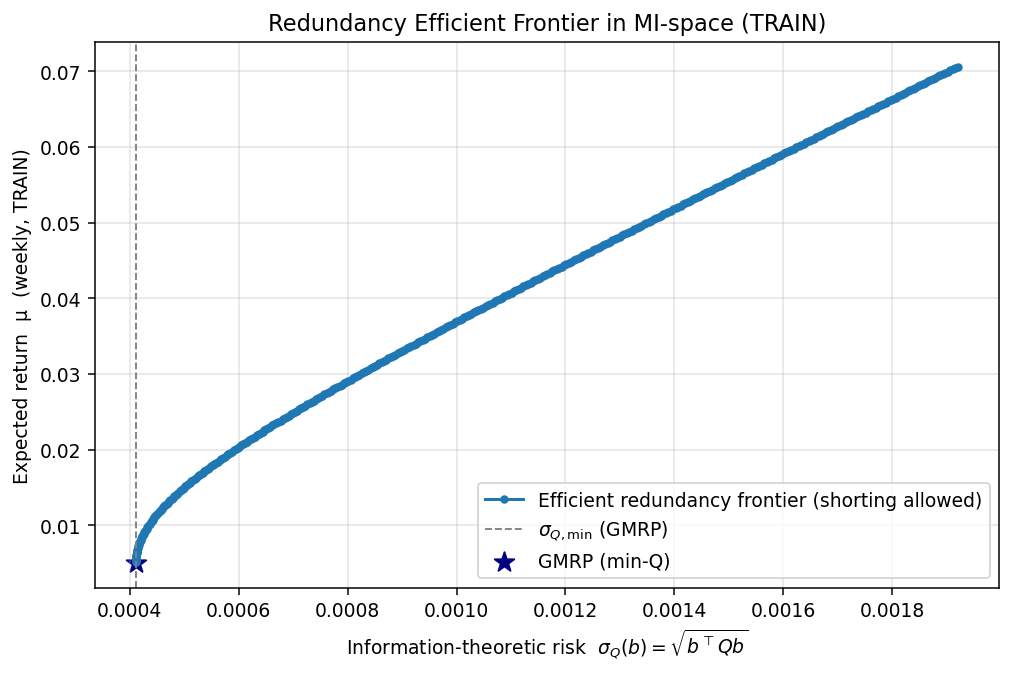

In [3]:
# MI kernel, alignment, GMRP, MI frontier

# Load and clean the MI kernel (bits). This is the raw dependence object for the MI-space frontier.
assert MI_FILE.exists(), f"Missing MI kernel: {MI_FILE}"
R_mi_raw = pd.read_parquet(MI_FILE)
R_mi = sanitize_kernel_bits(R_mi_raw, name="MI (TRAIN, bits)")

# Load training returns and build a label→ticker map so the return panel can align to the kernel.
df_train = load_train(TRAIN_UNIVERSE, TRAIN_CORE)
labels_full = list(R_mi.index)
lab2tkr = map_labels_to_tickers(R_mi, df_train)

# Wide return panel keyed by kernel labels (where a ticker mapping exists).
R_wide = pivot_train(df_train, lab2tkr, labels_full)

# Restrict to names that exist in both the kernel and the return panel.
common = [lbl for lbl in labels_full if lbl in R_wide.columns]
assert len(common) > 1, "No overlap between MI labels and returns panel."

# Build Q on the intersected label set, then PSD-project + ridge for invertibility.
Q0 = R_mi.loc[common, common].to_numpy(dtype="float64", copy=True)
Q_psd = nearest_psd(Q0, eps_eig=0.0)
ridge = choose_ridge(Q_psd, target_min=RIDGE_MIN_EIG, kappa_max=KAPPA_MAX)
Q = Q_psd + ridge * np.eye(Q_psd.shape[0])

evals = eigvalsh(Q)
print(
    f"[Q (MI)] ridge={ridge:.1e} | eig_min={evals.min():.3e} "
    f"| eig_max={evals.max():.3e} | cond≈{evals.max()/evals.min():.2e}"
)

# Align labels and estimate μ from the training return panel.
labels = common
n = len(labels)
mu = R_wide[labels].mean(axis=0).to_numpy(dtype="float64")

# Drop assets with undefined μ and keep Q consistent.
ok = np.isfinite(mu)
if ok.sum() < n:
    idx = np.flatnonzero(ok)
    mu = mu[idx]
    Q = Q[np.ix_(idx, idx)]
    labels = [labels[i] for i in idx]
    n = len(labels)

# One more PD check after dropping names.
w = eigvalsh(Q)
if w[0] <= 0:
    Q = nearest_psd(Q, eps_eig=RIDGE_MIN_EIG)

# Precompute the two key linear solves: Q^{-1}1 and Q^{-1}μ.
ones = np.ones(n)
try:
    Qi1  = solve(Q, ones)
    Qimu = solve(Q, mu)
except np.linalg.LinAlgError:
    Qi1,  *_ = lstsq(Q, ones, rcond=None)
    Qimu, *_ = lstsq(Q, mu,  rcond=None)

# Standard Markowitz-style scalars for the closed-form frontier.
A = float(ones @ Qi1)
B = float(ones @ Qimu)
C = float(mu   @ Qimu)
D = float(A*C - B*B)
assert D > 0, "Frontier ill-posed: D must be > 0 (check Q PD and μ variability)."

# GMRP is the minimum-Q portfolio under the budget constraint 1'b=1.
b_gmrp = Qi1 / A
sig_gmrp = sigma_Q(Q, b_gmrp)
J_gmrp   = 0.5 * float(b_gmrp @ (Q @ b_gmrp))
mu_gmrp  = float(mu @ b_gmrp)
print(f"[GMRP | MI] σ_Q,min={sig_gmrp:.6e} | J_min={J_gmrp:.6e} | μ={mu_gmrp:.6e}")

def redundancy_frontier_MI(
    Q: np.ndarray,
    Qi1: np.ndarray,
    Qimu: np.ndarray,
    A: float, B: float, C: float, D: float,
    mu_vec: np.ndarray,
    n_points: int = 161,
) -> tuple[pd.DataFrame, float]:
    """
    Markowitz analogue in MI-space: minimize b'Qb subject to 1'b=1 and μ'b=γ.
    Returns a DataFrame with ['sigma_Q','mu'] and the minimum-σ point gamma value.
    """
    gamma_mv = B / A
    mu_min, mu_max = float(mu_vec.min()), float(mu_vec.max())
    delta = max(mu_max - gamma_mv, gamma_mv - mu_min)
    if delta <= 0:
        delta = max(abs(gamma_mv) + 1e-6, 1e-4)

    gammas = np.linspace(gamma_mv - delta, gamma_mv + delta, n_points)
    rows = []
    for g in gammas:
        alpha = (C - B * g) / D
        beta  = (A * g - B) / D
        b = alpha * Qi1 + beta * Qimu
        b = b / b.sum()
        sig = sigma_Q(Q, b)
        mu_g = float(mu_vec @ b)
        rows.append((sig, mu_g))

    df = (
        pd.DataFrame(rows, columns=["sigma_Q", "mu"])
        .sort_values("sigma_Q")
        .reset_index(drop=True)
    )
    return df, gamma_mv

front_mi, gamma_mv = redundancy_frontier_MI(Q, Qi1, Qimu, A, B, C, D, mu, n_points=N_GAMMAS)

# Efficient branch: points with μ at least as high as the minimum-σ point.
front_mi_eff = (
    front_mi.loc[front_mi["mu"] >= mu_gmrp]
             .copy()
             .sort_values("sigma_Q")
)
print("Efficient frontier points (MI):", len(front_mi_eff))

# Plot the MI-space frontier and highlight the GMRP point.
fig, ax = plt.subplots(figsize=(7.6, 5.1))

ax.plot(
    front_mi_eff["sigma_Q"],
    front_mi_eff["mu"],
    "o-",
    lw=1.6,
    ms=3.5,
    label="Efficient redundancy frontier (shorting allowed)",
)

ax.axvline(sig_gmrp, color="gray", ls="--", lw=1.0, label=r"$\sigma_{Q,\min}$ (GMRP)")
ax.scatter(sig_gmrp, mu_gmrp, s=120, marker="*", color="navy", label="GMRP (min-Q)")

ax.set_xlabel(r"Information-theoretic risk  $\sigma_Q(b)=\sqrt{b^\top Q b}$")
ax.set_ylabel("Expected return  μ  (weekly, TRAIN)")
ax.set_title("Redundancy Efficient Frontier in MI-space (TRAIN)")
ax.grid(alpha=0.35)
ax.legend(loc="best")
fig.tight_layout()
plt.show()

[GMRP] σ_Q=4.109e-04 | μ=0.005072 | L1=2.20


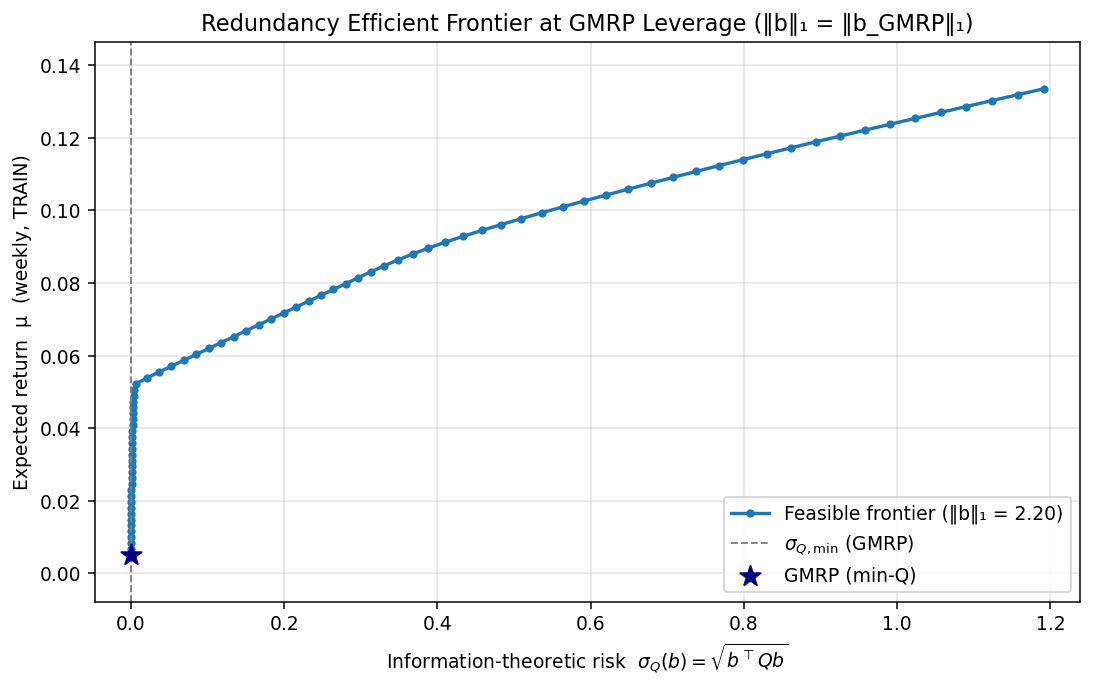

In [4]:
# L1-capped redundancy frontier at GMRP leverage
import cvxpy as cp

# Pull Q and mu from the previous cell (already aligned to the same label order).
Q_in  = Q
mu_in = mu

def as_np_Q_mu(Q_like, mu_like):
    # Normalize inputs into a symmetric numpy Q and a flat mu vector.
    Qn = np.asarray(Q_like, dtype=float)
    mu_arr = np.asarray(mu_like, dtype=float).ravel()
    assert Qn.shape[0] == Qn.shape[1] == mu_arr.shape[0], "Q and mu length mismatch"
    Qn = 0.5 * (Qn + Qn.T)
    return Qn, mu_arr

def sigma_Q_np(Qn, b):
    # Quadratic-form scale used throughout the MI-space plots.
    return float(np.sqrt(max(b @ (Qn @ b), 0.0)))

def pick_conic_solver():
    # ℓ1 constraints need a conic solver; pick the first one available.
    s = set(cp.installed_solvers())
    if "CLARABEL" in s:
        return "CLARABEL", dict(verbose=False, warm_start=True)
    if "SCS" in s:
        return "SCS", dict(verbose=False, warm_start=True, eps=1e-5, max_iters=200000)
    if "ECOS" in s:
        return "ECOS", dict(verbose=False, warm_start=True)
    raise RuntimeError("Install a conic solver for ℓ¹ constraints (e.g., `pip install scs`).")

def gmrp_unconstrained(Qn):
    # Closed-form unconstrained solution: w ∝ Q^{-1} 1.
    one = np.ones(Qn.shape[0])
    try:
        x = solve(Qn, one)
    except np.linalg.LinAlgError:
        x, *_ = lstsq(Qn, one, rcond=None)
    w = x / (one @ x)
    return w

def redundancy_min_L1(Qn, L1_max):
    # Left-most point under the ℓ1 cap: minimize 0.5 b'Qb subject to budget + leverage constraint.
    n = Qn.shape[0]
    b = cp.Variable(n)
    obj  = 0.5 * cp.quad_form(b, Qn)
    cons = [cp.sum(b) == 1, cp.norm1(b) <= float(L1_max)]

    solver, kw = pick_conic_solver()
    prob = cp.Problem(cp.Minimize(obj), cons)
    prob.solve(solver=solver, **kw)
    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError(f"Left-most solve (L1={L1_max}) not optimal: {prob.status}")

    w = np.array(b.value).ravel()
    return w / w.sum()

def redundancy_frontier_L1_aligned(
    Qn, mu_vec, L1_max, n_points: int = 61, mu_floor: float | None = None
):
    """
    Build the ℓ1-capped redundancy frontier by sweeping γ and solving:
      min 0.5 b'Qb  s.t. 1'b=1, ||b||_1<=L1_max, μ'b=γ

    The output is sorted left→right by sigma_Q, and includes the true left-most
    anchor point under the cap.
    """
    n = len(mu_vec)
    solver, kw = pick_conic_solver()

    w0 = redundancy_min_L1(Qn, L1_max)
    sig0 = sigma_Q_np(Qn, w0)
    mu0 = float(mu_vec @ w0)

    # Compute feasible μ-range under the same constraints so we don't ask for infeasible γ values.
    b = cp.Variable(n)
    cons = [cp.sum(b) == 1, cp.norm1(b) <= float(L1_max)]
    cp.Problem(cp.Maximize(mu_vec @ b), cons).solve(solver=solver, **kw)
    mu_max = float((mu_vec @ b).value)
    cp.Problem(cp.Minimize(mu_vec @ b), cons).solve(solver=solver, **kw)
    mu_min = float((mu_vec @ b).value)

    eps = max(1e-12, 1e-4 * (mu_max - mu_min))
    lo = mu_min + eps
    if mu_floor is not None:
        lo = max(lo, float(mu_floor) + eps)
    hi = mu_max - eps

    if not (lo < hi):
        rows = [dict(sigma_Q=sig0, mu=mu0, L1=float(np.abs(w0).sum()))]
        return pd.DataFrame(rows), (mu_min, mu_max)

    gammas = np.linspace(lo, hi, n_points)
    rows = [dict(sigma_Q=sig0, mu=mu0, L1=float(np.abs(w0).sum()))]
    w_prev = w0.copy()

    for g in gammas:
        b = cp.Variable(n)
        cons_g = [cp.sum(b) == 1, cp.norm1(b) <= float(L1_max), mu_vec @ b == float(g)]
        obj = 0.5 * cp.quad_form(b, Qn)
        prob = cp.Problem(cp.Minimize(obj), cons_g)
        b.value = w_prev
        prob.solve(solver=solver, **kw)
        if prob.status not in ("optimal", "optimal_inaccurate"):
            continue
        w = np.array(b.value).ravel()
        w = w / w.sum()
        rows.append(
            dict(
                sigma_Q=sigma_Q_np(Qn, w),
                mu=float(mu_vec @ w),
                L1=float(np.abs(w).sum()),
            )
        )
        w_prev = w

    df = pd.DataFrame(rows).dropna()
    if mu_floor is not None:
        df = df.loc[df["mu"] >= mu_floor - 1e-12].copy()
    df = df.sort_values("sigma_Q", kind="mergesort").reset_index(drop=True)
    sig_key = df["sigma_Q"].round(12)
    df = df.loc[~sig_key.duplicated(keep="first")].reset_index(drop=True)
    return df, (mu_min, mu_max)

# Convert to plain numpy arrays and recompute the baseline GMRP point.
Q_np, mu_np = as_np_Q_mu(Q_in, mu_in)

w_gmrp = gmrp_unconstrained(Q_np)
sig_gmrp = sigma_Q_np(Q_np, w_gmrp)
mu_gmrp  = float(mu_np @ w_gmrp)
L1_gmrp  = float(np.abs(w_gmrp).sum())
print(f"[GMRP] σ_Q={sig_gmrp:.3e} | μ={mu_gmrp:.6f} | L1={L1_gmrp:.2f}")

# Frontier under the exact leverage implied by the unconstrained GMRP solution.
front_L1, (mu_min_L1, mu_max_L1) = redundancy_frontier_L1_aligned(
    Q_np,
    mu_np,
    L1_max=L1_gmrp,
    n_points=80,
    mu_floor=mu_gmrp,
)

plt.figure(figsize=(8.2, 5.2))
plt.plot(
    front_L1["sigma_Q"],
    front_L1["mu"],
    "-o",
    ms=3.4,
    lw=1.8,
    color="#1f77b4",
    label=f"Feasible frontier (‖b‖₁ = {L1_gmrp:.2f})",
)
plt.axvline(sig_gmrp, color="gray", lw=1.0, ls="--", label=r"$\sigma_{Q,\min}$ (GMRP)")
plt.scatter(sig_gmrp, mu_gmrp, s=130, marker="*", color="navy", zorder=5, label="GMRP (min-Q)")

# Small padding so points don't sit directly on the axes.
xpad = 0.04 * max(front_L1["sigma_Q"].max() - front_L1["sigma_Q"].min(), 1e-12)
ypad = 0.10 * max(front_L1["mu"].max()      - front_L1["mu"].min(),       1e-12)
plt.xlim(front_L1["sigma_Q"].min() - xpad, front_L1["sigma_Q"].max() + xpad)
plt.ylim(front_L1["mu"].min() - ypad,      front_L1["mu"].max() + ypad)

plt.xlabel(r"Information-theoretic risk  $\sigma_Q(b)=\sqrt{b^\top Q b}$")
plt.ylabel("Expected return  μ  (weekly, TRAIN)")
plt.title("Redundancy Efficient Frontier at GMRP Leverage (‖b‖₁ = ‖b_GMRP‖₁)")
plt.grid(alpha=0.35)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

[GMV overlay] aligned N=1000 | μ=0.002538 | σ_Q=1.154e-01 | L1=3.37 | longs=532 | shorts=468


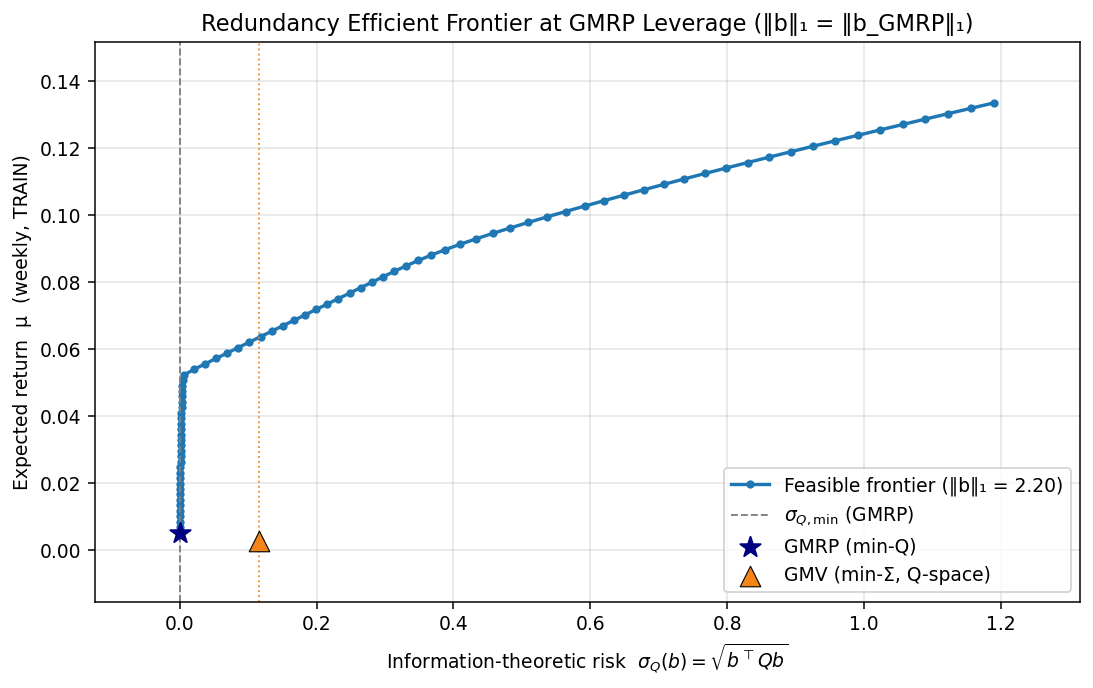

In [6]:
# GMV (Σ-based) overlay in MI-space
from sklearn.covariance import LedoitWolf

def _load_core_train(PROCESSED: Path, start="1997-01-01", end=None):
    # Load the weekly core panel for the training span (prefer the explicitly versioned slice).
    CORE_DEFAULT = PROCESSED / "crsp_weekly_core.parquet"
    CORE_ALT_B   = PROCESSED / "crsp_weekly_core_1997-01-01_to_2018-06-29.parquet"
    core_path = CORE_ALT_B if CORE_ALT_B.exists() else CORE_DEFAULT

    df = pd.read_parquet(core_path).copy()
    df["date"]   = pd.to_datetime(df["date"], errors="coerce")
    df["permno"] = pd.to_numeric(df["permno"], errors="coerce").astype("Int64")
    if "ticker" in df.columns:
        df["ticker"] = df["ticker"].astype(str).str.upper()

    if end is None:
        end = f"{ASOF_DATE:%Y-%m-%d}"
    df = df[(df["date"] >= start) & (df["date"] <= end)].copy()

    ret_col = "ret_total" if "ret_total" in df.columns else ("ret" if "ret" in df.columns else None)
    assert ret_col is not None, "No ret/ret_total in TRAIN core."
    return df, ret_col

def _asof_universe_permno(univ_file: Path, asof: pd.Timestamp) -> pd.Index:
    # Pull the PERMNO membership list at the as-of snapshot (or last snapshot <= asof).
    u = pd.read_parquet(univ_file).copy()
    u["date"]   = pd.to_datetime(u["date"], errors="coerce")
    u["permno"] = pd.to_numeric(u["permno"], errors="coerce").astype("Int64")

    if (u["date"] == asof).any():
        s = u[(u["date"] == asof) & u["in_universe"].fillna(False)]
    else:
        last_d = u.loc[u["date"] <= asof, "date"].max()
        s = u[(u["date"] == last_d) & u["in_universe"].fillna(False)]

    return pd.Index(s["permno"].dropna().astype(int).unique(), dtype=int)

def _label_to_permno_map(kernel_labels: list, permno2ticker: dict) -> dict:
    # Map kernel labels back to PERMNOs using a few common formats (PERMNO_####, trailing digits, ticker).
    tk_counts = pd.Series(list(permno2ticker.values())).value_counts()
    ticker2perm = {
        t: p for p, t in permno2ticker.items()
        if t and t in tk_counts and tk_counts.loc[t] == 1
    }

    lab2perm = {}
    for lbl in kernel_labels:
        s = str(lbl)

        m = re.search(r"PERMNO[_\-\s]*(\d{4,7})", s, flags=re.IGNORECASE)
        if m:
            lab2perm[lbl] = int(m.group(1))
            continue

        m = re.search(r"(\d{4,7})\s*$", s)
        if m:
            lab2perm[lbl] = int(m.group(1))
            continue

        t = s.split("—")[0].split("–")[0].split("-")[0].strip().upper()
        if t and t.isalpha() and t in ticker2perm:
            lab2perm[lbl] = int(ticker2perm[t])
            continue

    return lab2perm

# Build the as-of universe and pull the training core returns on that universe.
permnos_asof = _asof_universe_permno(TRAIN_UNIVERSE, ASOF_DATE)
core, RET_COL = _load_core_train(PROCESSED, start="1997-01-01", end=f"{ASOF_DATE:%Y-%m-%d}")
core = core[core["permno"].isin(permnos_asof)]

# PERMNO→ticker map at ASOF_DATE (last observation on/before ASOF_DATE).
snap = (
    core[core["date"] <= ASOF_DATE]
    .sort_values(["permno", "date"])
    .groupby("permno", observed=True)
    .tail(1)
)
permno2ticker = dict(
    zip(
        snap["permno"].astype(int),
        snap.get("ticker", pd.Series(index=snap.index, dtype=str)).astype(str).str.upper(),
    )
)

# Pivot returns wide by PERMNO so alignment is robust to ticker churn.
piv_pno = (
    core.loc[:, ["date", "permno", RET_COL]]
        .pivot_table(index="date", columns="permno", values=RET_COL, aggfunc="last")
        .sort_index()
        .dropna(how="all")
)
piv_pno.columns = piv_pno.columns.astype(int)

# Convert kernel labels to PERMNOs, then to a PERMNO→label map for renaming.
lab2perm = _label_to_permno_map(labels, permno2ticker)
perm2lab = {p: lbl for lbl, p in lab2perm.items() if p in piv_pno.columns}

common_perms = [p for p in piv_pno.columns if p in perm2lab]
if len(common_perms) < 2:
    raise RuntimeError("Could not align kernel labels to TRAIN returns via PERMNO mapping.")

train_wide_use = piv_pno.loc[:, common_perms].copy()
train_wide_use.columns = [perm2lab[p] for p in common_perms]

labels_use = [lbl for lbl in labels if lbl in train_wide_use.columns]

# Shrink Q and mu onto the aligned label set, preserving kernel order.
Q_use = Q[np.ix_([labels.index(lbl) for lbl in labels_use],
                 [labels.index(lbl) for lbl in labels_use])]
mu_use = mu[np.array([labels.index(lbl) for lbl in labels_use], dtype=int)]

# GMV weights from a stabilized covariance estimate (Ledoit–Wolf).
X = train_wide_use[labels_use].to_numpy(dtype=float, copy=True)
X = np.nan_to_num(X, nan=0.0)

lw = LedoitWolf(assume_centered=True).fit(X)
Sigma   = 0.5 * (lw.covariance_ + lw.covariance_.T)

# Tiny diagonal bump to avoid singular solves in edge cases.
tau     = 1e-10 * np.trace(Sigma) / Sigma.shape[0]
Sigma_r = Sigma + tau * np.eye(Sigma.shape[0])

one = np.ones(Sigma_r.shape[0])
try:
    x = solve(Sigma_r, one)
except np.linalg.LinAlgError:
    x, *_ = lstsq(Sigma_r, one, rcond=None)

w_gmv    = x / x.sum()
mu_gmv   = float(mu_use @ w_gmv)
sigQ_gmv = sigma_Q_np(Q_use, w_gmv)
L1_gmv   = float(np.abs(w_gmv).sum())

print(
    f"[GMV overlay] aligned N={len(labels_use)} | μ={mu_gmv:.6f} | "
    f"σ_Q={sigQ_gmv:.3e} | L1={L1_gmv:.2f} | "
    f"longs={(w_gmv>0).sum()} | shorts={(w_gmv<0).sum()}"
)

# Plot the L1-capped frontier (at GMRP leverage) and overlay the GMV point in Q-space.
fig, ax = plt.subplots(figsize=(8.2, 5.2))
ax.plot(
    front_L1["sigma_Q"],
    front_L1["mu"],
    "-o",
    ms=3.4,
    lw=1.8,
    color="#1f77b4",
    label=f"Feasible frontier (‖b‖₁ = {L1_gmrp:.2f})",
)
ax.axvline(sig_gmrp, color="gray", lw=1.0, ls="--", label=r"$\sigma_{Q,\min}$ (GMRP)")
ax.scatter(sig_gmrp, mu_gmrp, s=130, marker="*", color="navy", zorder=5, label="GMRP (min-Q)")

ax.axvline(sigQ_gmv, color="#F58518", ls=":", lw=1.0, alpha=0.9)
ax.scatter(
    sigQ_gmv,
    mu_gmv,
    s=120,
    marker="^",
    color="#F58518",
    edgecolor="black",
    linewidth=0.6,
    zorder=8,
    label="GMV (min-Σ, Q-space)",
)

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
xspan  = max(x1 - x0, 1e-12)
yspan  = max(y1 - y0, 1e-12)

ax.set_xlim(min(x0, sigQ_gmv, sig_gmrp) - 0.05 * xspan,
            max(x1, sigQ_gmv, sig_gmrp) + 0.05 * xspan)
ax.set_ylim(min(y0, mu0 := mu_gmrp, mu_gmv) - 0.08 * yspan,
            max(y1, mu0, mu_gmv)       + 0.08 * yspan)

ax.set_xlabel(r"Information-theoretic risk  $\sigma_Q(b)=\sqrt{b^\top Q b}$")
ax.set_ylabel("Expected return  μ  (weekly, TRAIN)")
ax.set_title("Redundancy Efficient Frontier at GMRP Leverage (‖b‖₁ = ‖b_GMRP‖₁)")
ax.grid(alpha=0.35)
ax.legend(loc="best")
fig.tight_layout()
plt.show()

Universe as-of: 1000 permnos
ret_train shape: (1122, 1000) | dates: 1997-01-03 → 2018-06-29
[coverage] kept 600/1000 assets (COVER_MIN=90%, VAR_FLOOR=1e-14)
[labels_clean] N=600 (matches Σ, μ_vec)
[Σ] Ledoit–Wolf shrinkage used (T=690, N=600)
[Σ] min_eig=2.126e-04 | cond≈1.89e+03
[A,B,C,D] A=1.815e+04  B=4.520e+01  C=7.137e-01  D=1.091e+04
[GMV] σ=0.007422 | μ=2.490070e-03 | L1=5.925
Efficient frontier points (Σ): 60
Loaded GMRP weights: (1000,)
[align] via PERMNO=1000, via TICKER=0 | covered=1000/1000
[GMRP in Σ] σ=0.023797 | μ=3.962406e-03


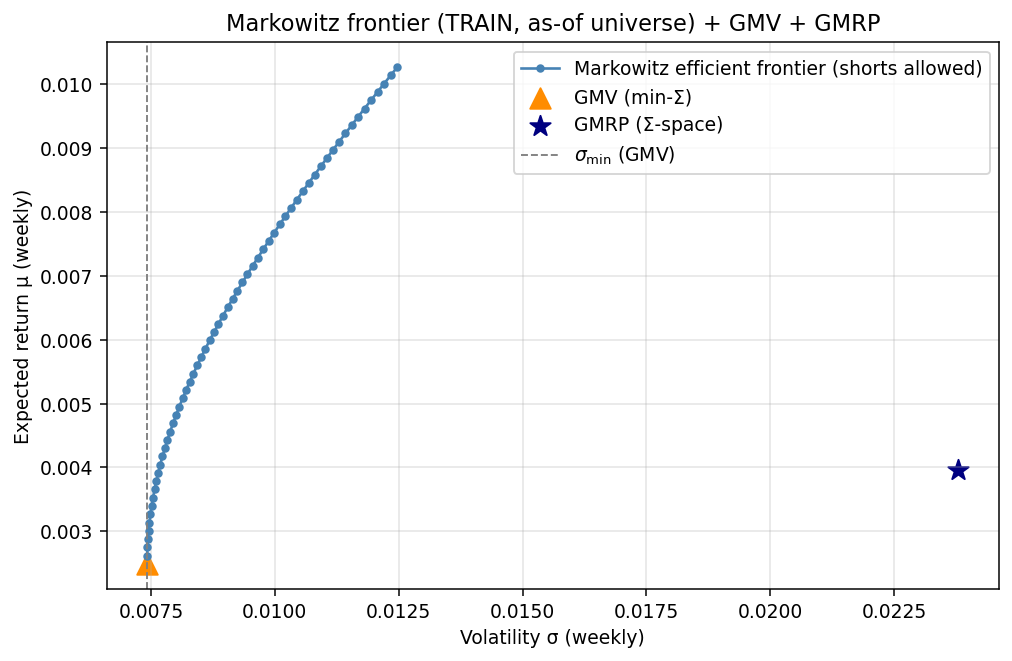

[check] left-most frontier == GMV? True


In [7]:
# Markowitz Σ-frontier (TRAIN) + GMV + GMRP
from pathlib import Path
from sklearn.covariance import LedoitWolf
from numpy.linalg import eigvalsh

# Training inputs and the precomputed GMRP weights file to overlay.
TRAIN_UNIVERSE = PROCESSED / "crsp_weekly_universe_1997-01-01_to_2018-06-29_top1000_liq20p_rebalance-monthly_W-FRI.parquet"
TRAIN_CORE     = PROCESSED / "crsp_weekly_core_1997-01-01_to_2018-06-29.parquet"
GMRP_PATH      = ANALYSIS  / "b_gmrp_unconstrained_qp_asof20180629_top1000_ridge1e-05.parquet"

ASOF = ASOF_DATE

# Universe membership list at ASOF (or last snapshot <= ASOF).
uni = pd.read_parquet(TRAIN_UNIVERSE).copy()
uni["date"]   = pd.to_datetime(uni["date"], errors="coerce")
uni["permno"] = pd.to_numeric(uni["permno"], errors="coerce").astype("Int64")

if (uni["date"] == ASOF).any():
    asof_slice = uni[(uni["date"] == ASOF) & (uni["in_universe"].fillna(False))]
else:
    last_date = uni.loc[uni["date"] <= ASOF, "date"].max()
    asof_slice = uni[(uni["date"] == last_date) & (uni["in_universe"].fillna(False))]

permnos_asof = asof_slice["permno"].dropna().astype(int).unique().tolist()
print(f"Universe as-of: {len(permnos_asof)} permnos")

# Load training returns, restrict to the as-of universe, and pivot wide by PERMNO.
core_S = pd.read_parquet(TRAIN_CORE).copy()
core_S["date"]   = pd.to_datetime(core_S["date"], errors="coerce")
core_S["permno"] = pd.to_numeric(core_S["permno"], errors="coerce").astype("Int64")
if "ticker" in core_S.columns:
    core_S["ticker"] = core_S["ticker"].astype(str).str.upper()

RET_COL_S = "ret_total" if "ret_total" in core_S.columns else "ret"
assert RET_COL_S in core_S.columns, f"Neither ret_total nor ret found in {TRAIN_CORE.name}"

core_sub = core_S[
    (core_S["date"] >= "1997-01-01")
    & (core_S["date"] <= ASOF)
    & (core_S["permno"].isin(permnos_asof))
]

ret_train = (
    core_sub.pivot_table(index="date", columns="permno", values=RET_COL_S, aggfunc="last")
            .sort_index()
            .dropna(how="all")
            .clip(lower=-0.99, upper=5.0)
)
ret_train.columns = ret_train.columns.astype("Int64").astype(str)
labels_all = ret_train.columns.tolist()

print(
    "ret_train shape:",
    ret_train.shape,
    "| dates:",
    ret_train.index.min().date(),
    "→",
    ret_train.index.max().date(),
)

# Σ estimation and Markowitz frontier settings.
USE_SHRINKAGE = True
COVER_MIN     = 0.90
VAR_FLOOR     = 1e-14
RIDGE_SCALE   = 1e-10
TOL_D         = 1e-12
N_GAMMAS      = 121

# Filter out names that are too sparse or essentially constant.
covg = ret_train.notna().mean()
vvar = ret_train.var().astype(float)
keep = ret_train.columns[(covg >= COVER_MIN) & (vvar > VAR_FLOOR)].tolist()
X = ret_train[keep].copy()
print(
    f"[coverage] kept {len(keep)}/{ret_train.shape[1]} assets "
    f"(COVER_MIN={COVER_MIN:.0%}, VAR_FLOOR={VAR_FLOOR:g})"
)

labels_clean = list(X.columns.astype(str))
print(f"[labels_clean] N={len(labels_clean)} (matches Σ, μ_vec)")

# Weekly mean returns.
mu_vec = X.mean().astype(float).to_numpy()

# Covariance estimate: Ledoit–Wolf when feasible; otherwise fall back to sample covariance.
if USE_SHRINKAGE:
    X_lw = X.dropna(axis=0, how="any")
    if X_lw.shape[0] >= 100 and X_lw.shape[1] >= 2:
        lw = LedoitWolf().fit(X_lw.to_numpy())
        Sigma = lw.covariance_
        print(f"[Σ] Ledoit–Wolf shrinkage used (T={X_lw.shape[0]}, N={X_lw.shape[1]})")
    else:
        Sigma = X.cov().astype(float).to_numpy()
        print("[Σ] Not enough complete rows → using pairwise sample covariance")
else:
    Sigma = X.cov().astype(float).to_numpy()
    print("[Σ] Using plain sample covariance")

# Symmetrize and add a tiny diagonal ridge for numerical stability.
n = Sigma.shape[0]
Sigma = 0.5 * (Sigma + Sigma.T)
tau = RIDGE_SCALE * np.trace(Sigma) / max(n, 1)
Sigma_r = Sigma + tau * np.eye(n)

eigvals = eigvalsh(Sigma_r)
cond = float(eigvals.max() / max(eigvals.min(), 1e-18))
print(f"[Σ] min_eig={eigvals.min():.3e} | cond≈{cond:.2e}")

# Closed-form Markowitz scalars.
ones_S = np.ones(n)
try:
    S1  = solve(Sigma_r, ones_S)
    Sm  = solve(Sigma_r, mu_vec)
except np.linalg.LinAlgError:
    S1, *_ = lstsq(Sigma_r, ones_S, rcond=None)
    Sm, *_ = lstsq(Sigma_r, mu_vec,  rcond=None)

A_S = float(ones_S @ S1)
B_S = float(ones_S @ Sm)
C_S = float(mu_vec @ Sm)
D_S = float(A_S * C_S - B_S * B_S)
print(f"[A,B,C,D] A={A_S:.3e}  B={B_S:.3e}  C={C_S:.3e}  D={D_S:.3e}")

if not (D_S > TOL_D):
    raise RuntimeError(
        "Frontier ill-posed (D≤0). μ may be nearly constant or Σ singular. "
        "Try relaxing COVER_MIN or disable shrinkage."
    )

# GMV is the left-most point under Σ with 1'w=1.
b_gmv_S = S1 / A_S
sigma_gmv = float(np.sqrt(max(b_gmv_S @ (Sigma @ b_gmv_S), 0.0)))
mu_gmv_S  = float(mu_vec @ b_gmv_S)
L1_gmv_S  = float(np.abs(b_gmv_S).sum())
print(f"[GMV] σ={sigma_gmv:.6f} | μ={mu_gmv_S:.6e} | L1={L1_gmv_S:.3f}")

def markowitz_frontier(mu_vec, Sigma_r, S1, Sm, A, B, C, D, n_points=121):
    # Markowitz frontier in closed form: min w'Σw subject to 1'w=1 and μ'w=γ.
    gamma_mv = B / A
    mu_min, mu_max = float(mu_vec.min()), float(mu_vec.max())
    delta = max(mu_max - gamma_mv, gamma_mv - mu_min)
    if delta <= 0:
        delta = max(abs(gamma_mv) + 1e-6, 1e-4)

    gammas = np.linspace(gamma_mv - delta, gamma_mv + delta, n_points)
    rows = []
    for g in gammas:
        alpha = (C - B * g) / D
        beta  = (A * g - B) / D
        w = alpha * S1 + beta * Sm
        w = w / w.sum()
        var = float(w @ (Sigma_r @ w))
        rows.append((np.sqrt(max(var, 0.0)), float(mu_vec @ w), w))

    df = pd.DataFrame(rows, columns=["sigma", "mu", "weights"]).sort_values("sigma")
    return df.reset_index(drop=True)

front_mv = markowitz_frontier(mu_vec, Sigma_r, S1, Sm, A_S, B_S, C_S, D_S, n_points=N_GAMMAS)
front_mv_eff = front_mv.loc[front_mv["mu"] >= mu_gmv_S].copy().sort_values("sigma")
print("Efficient frontier points (Σ):", front_mv_eff.shape[0])

# Load GMRP weights and align them onto the PERMNO axis used for Σ.
def parse_label_to_ticker_and_permno(label: str):
    s = str(label).strip()

    if "—" in s:
        left = s.split("—")[0].strip().upper()
        if left and left.isalpha():
            return left, None

    m = re.search(r"(\d{4,7})$", s)
    pno = int(m.group(1)) if m else None
    parts = re.split(r"[ _\-\|]+", s)
    tkr = parts[0].upper() if parts and parts[0].isalpha() else None
    return tkr, pno

def ticker_to_permno_asof(df: pd.DataFrame, asof: pd.Timestamp) -> dict[str, int]:
    # As-of ticker→permno map (last observation on/before ASOF).
    if "ticker" not in df.columns or "permno" not in df.columns:
        return {}
    d = df.loc[:, ["date", "permno", "ticker"]].copy()
    d["date"]   = pd.to_datetime(d["date"], errors="coerce")
    d["ticker"] = d["ticker"].astype(str).str.upper()
    d = d.dropna(subset=["permno", "ticker"])
    d = d[d["date"] <= asof].sort_values(["ticker", "date"])
    snap = d.groupby("ticker", observed=True).tail(1)
    return dict(zip(snap["ticker"], snap["permno"].astype(int)))

tkr2pno = ticker_to_permno_asof(core_S, ASOF)

obj = pd.read_parquet(GMRP_PATH)
if isinstance(obj, pd.Series):
    b_gmrp_raw = obj.astype(float)
else:
    col = next((c for c in ["weight", "weights", "b", "w"] if c in obj.columns), None)
    if col is None:
        num = obj.select_dtypes(include="number")
        col = num.columns[0]
    b_gmrp_raw = obj[col].astype(float)
print("Loaded GMRP weights:", b_gmrp_raw.shape)

ids_full = pd.Index(ret_train.columns.astype(str), dtype="object")
weights_full = pd.Series(0.0, index=ids_full)

hits_p = hits_t = 0
for lbl, w in b_gmrp_raw.items():
    tkr, pno = parse_label_to_ticker_and_permno(lbl)
    key = None

    if pno is not None:
        key = str(pno)
        if key in ids_full:
            weights_full.loc[key] += float(w)
            hits_p += 1
            continue

    if (key is None) and (tkr is not None) and (tkr in tkr2pno):
        p_eff = str(tkr2pno[tkr])
        if p_eff in ids_full:
            weights_full.loc[p_eff] += float(w)
            hits_t += 1

if weights_full.sum() <= 0:
    raise RuntimeError("Failed to align any GMRP weights to TRAIN permnos.")

weights_full = weights_full / weights_full.sum()
print(
    f"[align] via PERMNO={hits_p}, via TICKER={hits_t} | "
    f"covered={(weights_full != 0).sum()}/{len(ids_full)}"
)

weights_clean = weights_full.reindex(labels_clean).fillna(0.0)
if weights_clean.sum() <= 0:
    raise RuntimeError("GMRP weights have zero mass after filtering to labels_clean.")

b_gmrp_S = (weights_clean / weights_clean.sum()).to_numpy(dtype=float)
mu_gmrp_S = float(mu_vec @ b_gmrp_S)
sigma_gmrp = float(np.sqrt(max(b_gmrp_S @ (Sigma @ b_gmrp_S), 0.0)))
print(f"[GMRP in Σ] σ={sigma_gmrp:.6f} | μ={mu_gmrp_S:.6e}")

# Plot the Σ-frontier with GMV and the GMRP point evaluated in Σ-space.
ANNUALIZE = False
front_plot = front_mv_eff.copy()
x_gmv,  y_gmv  = sigma_gmv,  mu_gmv_S
x_gmrp, y_gmrp = sigma_gmrp, mu_gmrp_S

if ANNUALIZE:
    front_plot["sigma"] = np.sqrt(52.0) * front_plot["sigma"]
    front_plot["mu"]    = 52.0 * front_plot["mu"]
    x_gmv,  y_gmv  = np.sqrt(52.0)*sigma_gmv,  52.0*mu_gmv_S
    x_gmrp, y_gmrp = np.sqrt(52.0)*sigma_gmrp, 52.0*mu_gmrp_S
    y_lab = "Expected return (annualized)"
    x_lab = "Volatility σ (annualized)"
else:
    y_lab = "Expected return μ (weekly)"
    x_lab = "Volatility σ (weekly)"

plt.figure(figsize=(7.6, 5.0))
plt.plot(
    front_plot["sigma"],
    front_plot["mu"],
    "o-",
    ms=3.5,
    lw=1.4,
    color="steelblue",
    label="Markowitz efficient frontier (shorts allowed)",
)
plt.scatter(x_gmv,  y_gmv,  s=120, marker="^", color="darkorange", label="GMV (min-Σ)")
plt.scatter(x_gmrp, y_gmrp, s=130, marker="*", color="navy",        label="GMRP (Σ-space)")
plt.axvline(x_gmv, color="gray", ls="--", lw=1.0, label=r"$\sigma_{\min}$ (GMV)")

plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.title("Markowitz frontier (TRAIN, as-of universe) + GMV + GMRP")
plt.grid(alpha=0.35)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Sanity: left-most frontier point should match GMV.
left = front_mv.iloc[front_mv["sigma"].argmin()]
ok_left = np.allclose([left["sigma"], left["mu"]], [sigma_gmv, mu_gmv_S], rtol=1e-6, atol=1e-10)
print(f"[check] left-most frontier == GMV? {ok_left}")

GMV: σ=0.007422, μ=0.002490
Frontier leftmost: σ=0.007926, μ=0.002551


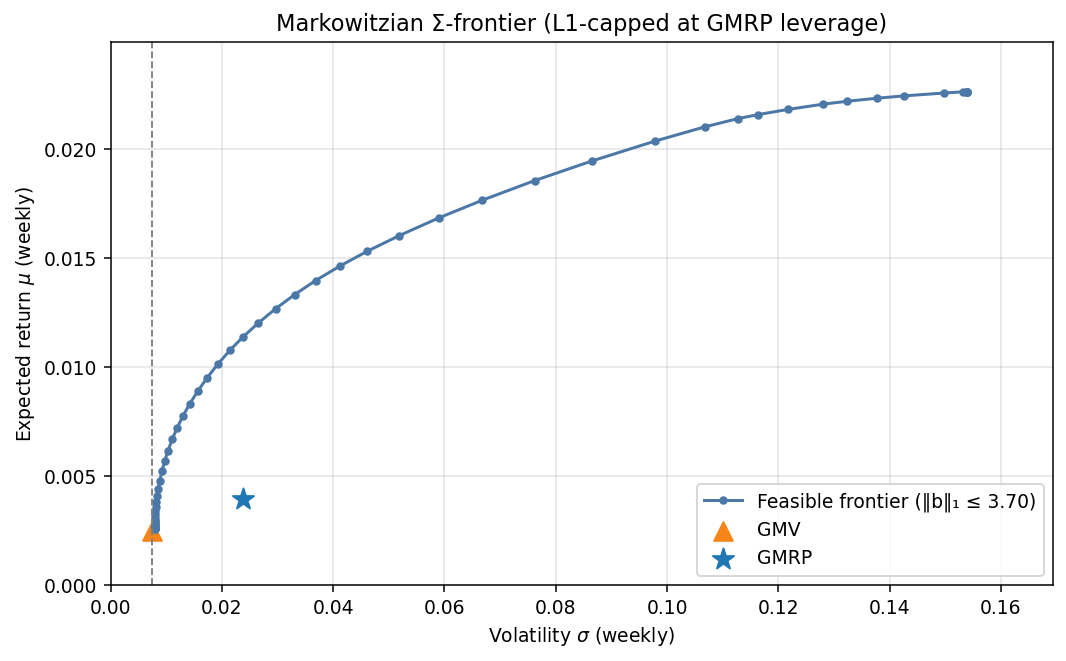

In [8]:
# Markowitz Σ-frontier with L1 cap = ‖b_GMRP‖₁
import cvxpy as cp

def feasible_frontier_penalty(Q, mu, L1_max, n_points=60, lam_max=None, warm_start=True):
    """
    Build an L1-capped Σ-frontier by sweeping a Lagrange multiplier on expected return:

        min_b  0.5 * b^T Q b - lam * mu^T b
        s.t.   1^T b == 1,  ||b||_1 <= L1_max

    Returns a DataFrame with ['sigma','mu','L1','lam','w'] sorted by sigma.
    """
    n = len(mu)
    b = cp.Variable(n)
    ones = np.ones(n)
    cons = [cp.sum(b) == 1, cp.norm1(b) <= L1_max]

    rows = []

    # Anchor at lam = 0: minimum variance portfolio under the L1 cap.
    obj0 = 0.5 * cp.quad_form(b, Q)
    prob0 = cp.Problem(cp.Minimize(obj0), cons)
    prob0.solve(solver=cp.SCS, verbose=False)
    if b.value is None:
        prob0.solve(solver=cp.ECOS, verbose=False)
    if b.value is not None:
        w0 = b.value.copy()
        rows.append(
            {
                "sigma": float(np.sqrt(max(w0 @ (Q @ w0), 0.0))),
                "mu": float(mu @ w0),
                "L1": float(np.sum(np.abs(w0))),
                "lam": 0.0,
                "w": w0,
            }
        )
    w_prev = b.value.copy() if b.value is not None else None

    # If lam_max isn't specified, increase it until the mu gain starts saturating.
    if lam_max is None:
        lam_max = 1.0
        last_mu = None
        for _ in range(10):
            lam_test = lam_max
            obj = 0.5 * cp.quad_form(b, Q) - lam_test * (mu @ b)
            prob = cp.Problem(cp.Minimize(obj), cons)
            if warm_start and w_prev is not None:
                b.value = w_prev
            prob.solve(solver=cp.SCS, verbose=False)
            if b.value is None:
                lam_max *= 2.0
                continue
            mu_t = float(mu @ b.value)
            if last_mu is not None and abs(mu_t - last_mu) < 1e-4 * max(1.0, abs(mu_t)):
                break
            last_mu = mu_t
            lam_max *= 2.0

        w_prev = rows[-1]["w"] if rows else None
        b.value = None

    # Positive lam grid (log spaced) gives more resolution near the variance-minimizing end.
    lam_grid = np.geomspace(1e-4, lam_max, num=n_points)
    for lam in lam_grid:
        obj = 0.5 * cp.quad_form(b, Q) - lam * (mu @ b)
        prob = cp.Problem(cp.Minimize(obj), cons)
        if warm_start and w_prev is not None:
            b.value = w_prev
        prob.solve(solver=cp.SCS, verbose=False)
        if b.value is None:
            prob.solve(solver=cp.ECOS, verbose=False)
        if b.value is None:
            continue
        w = b.value
        rows.append(
            {
                "sigma": float(np.sqrt(max(w @ (Q @ w), 0.0))),
                "mu": float(mu @ w),
                "L1": float(np.sum(np.abs(w))),
                "lam": lam,
                "w": w.copy(),
            }
        )
        w_prev = w.copy()

    df = pd.DataFrame(rows).dropna().sort_values("sigma").reset_index(drop=True)
    return df

# Cap leverage at the L1 norm implied by the GMRP weights (so the comparison is apples-to-apples).
L1_cap_S = float(np.abs(b_gmrp_S).sum())
front_pen = feasible_frontier_penalty(Sigma_r, mu_vec, L1_max=L1_cap_S, n_points=60)

print(f"GMV: σ={sigma_gmv:.6f}, μ={mu_gmv_S:.6f}")
print(
    f"Frontier leftmost: σ={front_pen['sigma'].iloc[0]:.6f}, "
    f"μ={front_pen['mu'].iloc[0]:.6f}"
)

# Plot the L1-capped Σ frontier with GMV and the GMRP point overlaid.
plt.figure(figsize=(8, 5))

plt.plot(
    front_pen["sigma"],
    front_pen["mu"],
    "o-",
    color="#4C78A8",
    lw=1.6,
    ms=3.5,
    label=f"Feasible frontier (‖b‖₁ ≤ {L1_cap_S:.2f})",
)

plt.scatter(sigma_gmv,  mu_gmv_S,  s=100, marker="^", color="#F58518", label="GMV")
plt.scatter(sigma_gmrp, mu_gmrp_S, s=140, marker="*", color="#1F77B4", label="GMRP")
plt.axvline(sigma_gmv, color="gray", linestyle="--", linewidth=1.0)

x_hi = max(front_pen["sigma"].max(), sigma_gmrp) * 1.10
y_lo = 0.0
y_hi = max(front_pen["mu"].max(), mu_gmrp_S) * 1.10
plt.xlim(0.0, x_hi)
plt.ylim(y_lo, y_hi)

plt.xlabel("Volatility $\\sigma$ (weekly)")
plt.ylabel("Expected return $\\mu$ (weekly)")
plt.title("Markowitzian Σ-frontier (L1-capped at GMRP leverage)")
plt.grid(alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()